In [1]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import json
import os
import sys
sys.path.append("../lib")
from dataUtils import *
import cPickle as pickle
import cv2
from collections import Counter
from scipy.interpolate import UnivariateSpline


In [2]:
#ClassFile = "../Logs/classes.json"
ClassFile = "../Logs/english_label.txt"


unpopular_vineScores = "../Logs/MVSO_fine_vine_unpopular_probs.csv"

#selfieScores = "../Logs/selfieSentibankProbs.csv"
sentibank_scores = "../Logs/sentibank_baseline_final.csv"

#vineANPs = "../Logs/sampled_vine_ANPS_final.pk"
unpop_vineANPs = "../Logs/MVSO_fine_vine_unpopular_ANPs.pk"
#selfiePaths = "../Logs/selfiePaths.txt"


#selfiePopularityFile = "../Logs/selfie_dataset.txt"

root = "../vinedata/Data/"

visitedList = "../Logs/sampledVids.data"

postFile = "../Logs/postsMapping.csv"

# sentimentFile = "../Logs/ANP_Sentiments.txt"

sampled_img_list = "../Logs/sampled_sentibank_image.txt"

revisedSentimentFile = "../Logs/revised_ANP_sentiments.csv"

In [3]:
unpopular_vineProbs = np.loadtxt(unpopular_vineScores, delimiter=',')
print unpopular_vineProbs.shape

(36661, 4342)


In [4]:
def get_ANP_ID_List(pickleList , nameIdx):
    ANPs = []
    IDs = []
    for line in pickleList:
        ids = line.split(',')[0].split('/')[nameIdx].split('_')[0]
        IDs.append(ids)
        ANPs.append(line.split(',')[1])
    return IDs , ANPs

def get_vid_senti(pickle , index , nameidx):
    oldId = pickle[index].split(',')[0].split('/')[nameidx].split('_')[0]
    seqDict = dict()
    indexList = []
    sequence = pickle[index].split(',')[0].split('/')[nameidx].split('_')[1].split('.')[0]
    seqDict[int(sequence)] = str(pickle[index].split(',')[1])
    indexList.append(index)
    index+=1
    #print index
    while (index < len(pickle) and (pickle[index].split(',')[0].split('/')[nameidx].split('_')[0] == oldId)):
        sequence = pickle[index].split(',')[0].split('/')[nameidx].split('_')[1].split('.')[0]
        seqDict[int(sequence)] = str(pickle[index].split(',')[1])
        indexList.append(index)
        index += 1
    seqDict['indexList'] = indexList
    return seqDict , oldId , index

#This function maps each video with a dictionary entry that has list of all ANPS per frame
#and an index list to find them
def get_VID_ANP_List(pickle, nameidx):
    megaDict = dict()
    i = 0
    print len(pickle)
    while i < len(pickle):           
        subDict , postId , i = get_vid_senti(pickle , i , nameidx)
        megaDict[int(postId)] = subDict
    return megaDict


def pruneMegaDict(megadict , filterindices):
    filteredList = dict()
    for entry in megadict:
        commns = set(megadict[entry]['indexList']).intersection(filterindices)
        if len(commns) >= 6:
            filteredList[entry] = megadict[entry]
    return filteredList

def readJson(path):
    f = open(path)
    data = json.loads(f.read())
    return data


In [5]:

f = open(ClassFile ,'r')
sentibankClasses = f.readlines()
f.close()

maxVecs = np.zeros(len(unpopular_vineProbs))
for i in range(len(unpopular_vineProbs)):
    maxVecs[i] = np.max(unpopular_vineProbs[i])
print np.mean(maxVecs) , np.median(maxVecs) , np.var(maxVecs)

0.0221606246623 0.0150964222848 0.00101608409988


In [6]:
unpop_vineList = readLists(unpop_vineANPs)
unpop_idList, unpop_anpList = get_ANP_ID_List(unpop_vineList , 5)

In [7]:
print unpop_idList[1000] , unpop_anpList [1000]

1378092411129352192 modern_jive


In [8]:
unpop_vineList = readLists(unpop_vineANPs)
unpop_idList, unpop_anpList = get_ANP_ID_List(unpop_vineList , 5)

In [9]:
megaDict_unpop = get_VID_ANP_List(unpop_vineList , 5)

36661


In [10]:
postIds_unpop = []
for line in unpop_vineList:
    arr = line.split('/')
    i = int(arr[5].split('_')[0])
    postIds_unpop.append(i)

In [12]:
sentidict0 = readSentiments()
sentidict = readRevisedSentiments()

In [15]:
senti_matrix = np.zeros((len(megaDict_unpop),12))
ANP_matrix = list()
print unpop_senti_matrix.shape

i = 0
misses = 0
unpop_postIdFilteredList = []
for entry in megaDict_unpop:
    unpop_postIdFilteredList.append(entry)
    ANPEntry = list()
    for j in range(1,13):
        
        if j in megaDict_unpop[entry]:
            senti_matrix[i][j-1] = sentidict[megaDict_unpop[entry][j]] \
            if (megaDict_unpop[entry][j] in sentidict) \
            else sentidict[megaDict_unpop[entry][j-1]]
            
            ANPEntry.append(megaDict_unpop[entry][j])
        else:
            last = ANPEntry[-1]
            ANPEntry.append(last)
            senti_matrix[i][j-1] = senti_matrix[i][j-2]
            misses += 1
    ANP_matrix.append(ANPEntry)
    i += 1
print misses

(2999, 12)
2127


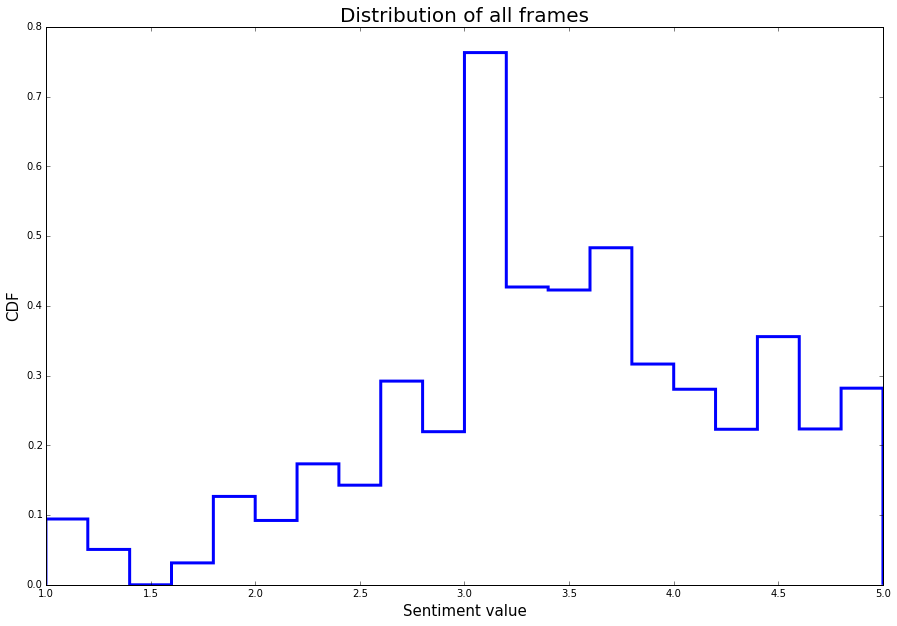

In [16]:
senti_vector = np.reshape(senti_matrix, senti_matrix.shape[0]*senti_matrix.shape[1])
fig, ax = plt.subplots()
fig.set_size_inches(15, 10)
plt.hist(senti_vector, 20, normed=1,histtype='step', cumulative=False,linewidth = 3.0)
plt.title("Distribution of all frames", fontsize = 20)
plt.xlabel("Sentiment value",fontsize = 15)
plt.ylabel("CDF",fontsize = 15)
plt.show()

In [17]:
maxGraph = np.zeros(senti_matrix.shape[1])
minGraph = np.zeros(senti_matrix.shape[1])
varMaxGraph = np.zeros(senti_matrix.shape[1])
varMinGraph = np.zeros(senti_matrix.shape[1])
differenceList = []
id1 = []
id2 = []
for i in range(len(senti_matrix)):
    a = max(senti_matrix[i])
    b = min(senti_matrix[i])
    median_sent = np.median(senti_matrix[i])
    diff = a - b
    
    diff2 = a - median_sent
    if diff > 0.5:
        ind1 = senti_matrix[i].tolist().index(a)
        if ind1 < 2:
             id1.append(i)
        maxGraph[ind1] += 1
        ind2 = senti_matrix[i].tolist().index(b)
        if ind2 < 2:
             id2.append(i)
        minGraph[ind2] += 1
        differenceList.append(diff)
    
    
maxGraph = maxGraph/senti_matrix.shape[0]
minGraph = minGraph/senti_matrix.shape[0]
print maxGraph
print minGraph
print senti_matrix.shape
print np.sum(maxGraph),np.sum(minGraph)
print len(id1) , len(id2)

[ 0.19739913  0.0846949   0.08002668  0.07169056  0.06102034  0.05068356
  0.05201734  0.04834945  0.04701567  0.08569523  0.03701234  0.02634211]
[ 0.18472824  0.08369456  0.07669223  0.06635545  0.07535845  0.05501834
  0.05035012  0.06102034  0.04268089  0.03767923  0.07502501  0.03334445]
(2999, 12)
0.841947315772 0.841947315772
846 805


In [18]:
c3 = list(set(id1).intersection(id2))
len(c3)

198

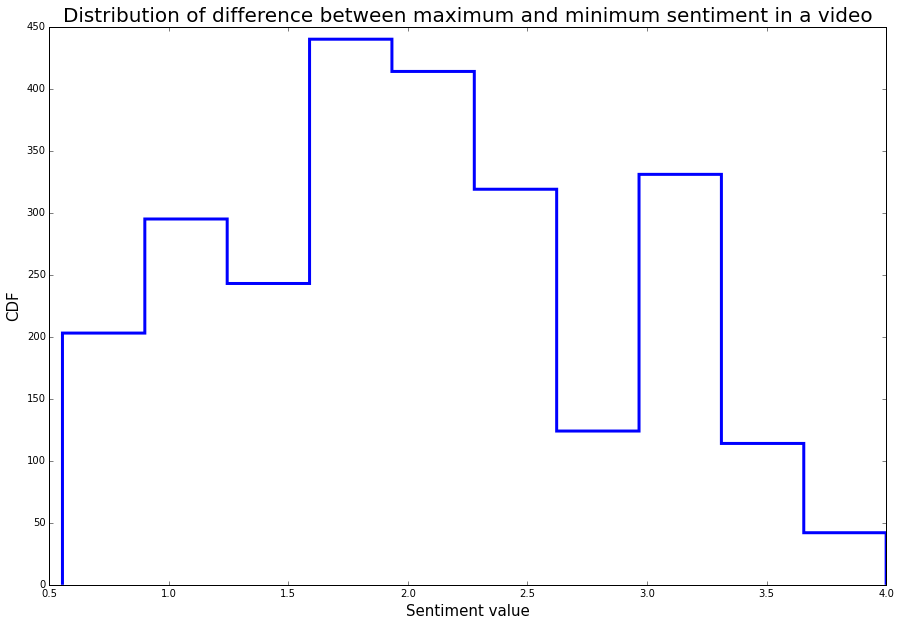

In [19]:
fig, ax = plt.subplots()
fig.set_size_inches(15, 10)
n, bins, patches = plt.hist(differenceList, 10, normed=0,histtype='step', cumulative=False,linewidth = 3.0)
plt.title("Distribution of difference between maximum and minimum sentiment in a video", fontsize = 20)
plt.xlabel("Sentiment value",fontsize = 15)
plt.ylabel("CDF",fontsize = 15)
plt.show()

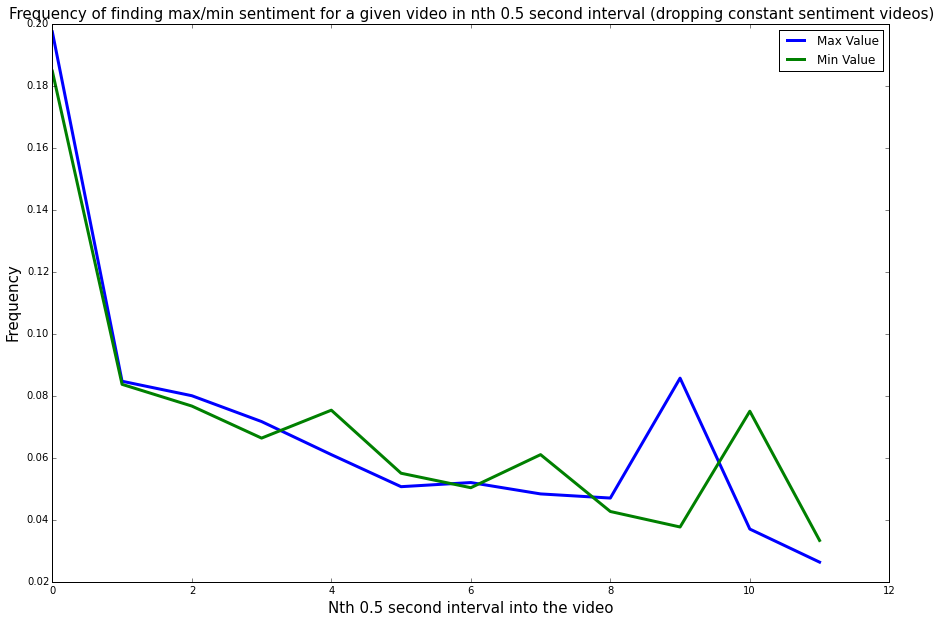

In [20]:
fig, ax = plt.subplots()
fig.set_size_inches(15, 10)
plt.title("Frequency of finding max/min sentiment for a given video in nth 0.5 second interval (dropping constant sentiment videos)", fontsize = 15)
plt.xlabel("Nth 0.5 second interval into the video",fontsize = 15)
plt.ylabel("Frequency",fontsize = 15)
plt.plot(maxGraph,linewidth = 3.0)
plt.plot(minGraph,linewidth = 3.0)
plt.legend(['Max Value', 'Min Value'   
           ])
plt.show()

In [21]:
from scipy.cluster.vq import kmeans,vq
from scipy.spatial.distance import minkowski

centroid_list = []
id_list = []
for i in range(1 , 12):
    centroids,_ = kmeans(senti_matrix,i)
    idx,_ = vq(senti_matrix,centroids)
    centroid_list.append(centroids)
    id_list.append(idx)
    
SSE_values = np.zeros(len(id_list))
for i in range(len(centroid_list)):
    for j in range(len(centroid_list[i])):
        vecs = senti_matrix[id_list[i]==j,:]
        #print vecs.shape
        cent = centroid_list[i][j]
        SSE_1 = 0.0
        for vec in vecs:
            SSE_1 = SSE_1 + minkowski(vec,cent,2)
        SSE_values[j] = SSE_values[j] + SSE_1
for i in range(len(SSE_values)):
    SSE_values[i] = SSE_values[i]/(i+1)

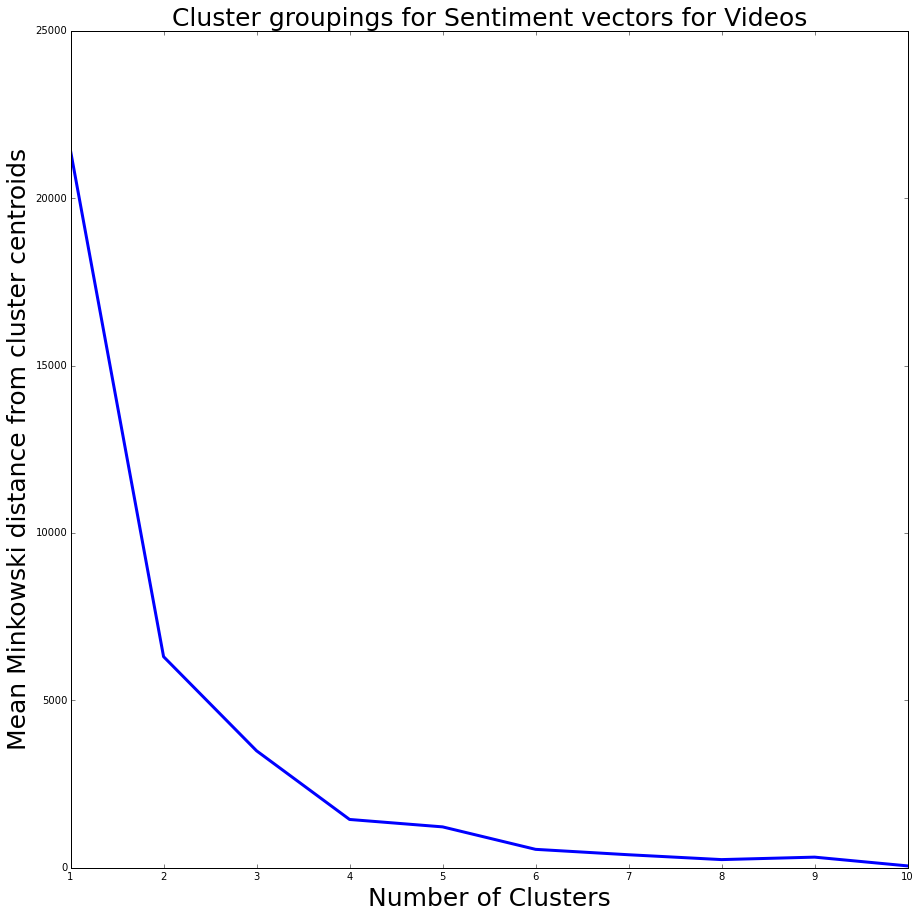

In [22]:
fig, ax = plt.subplots()
fig.set_size_inches(15, 15)
plt.rc('xtick', labelsize=20) 
plt.rc('ytick', labelsize=20)
x = np.arange(1,11)
plt.plot(x,SSE_values[:10] ,linewidth = 3.0)
plt.xlabel("Number of Clusters", fontsize = 25)
plt.ylabel("Mean Minkowski distance from cluster centroids", fontsize = 25)
plt.title("Cluster groupings for Sentiment vectors for Videos", fontsize = 25)
plt.show()

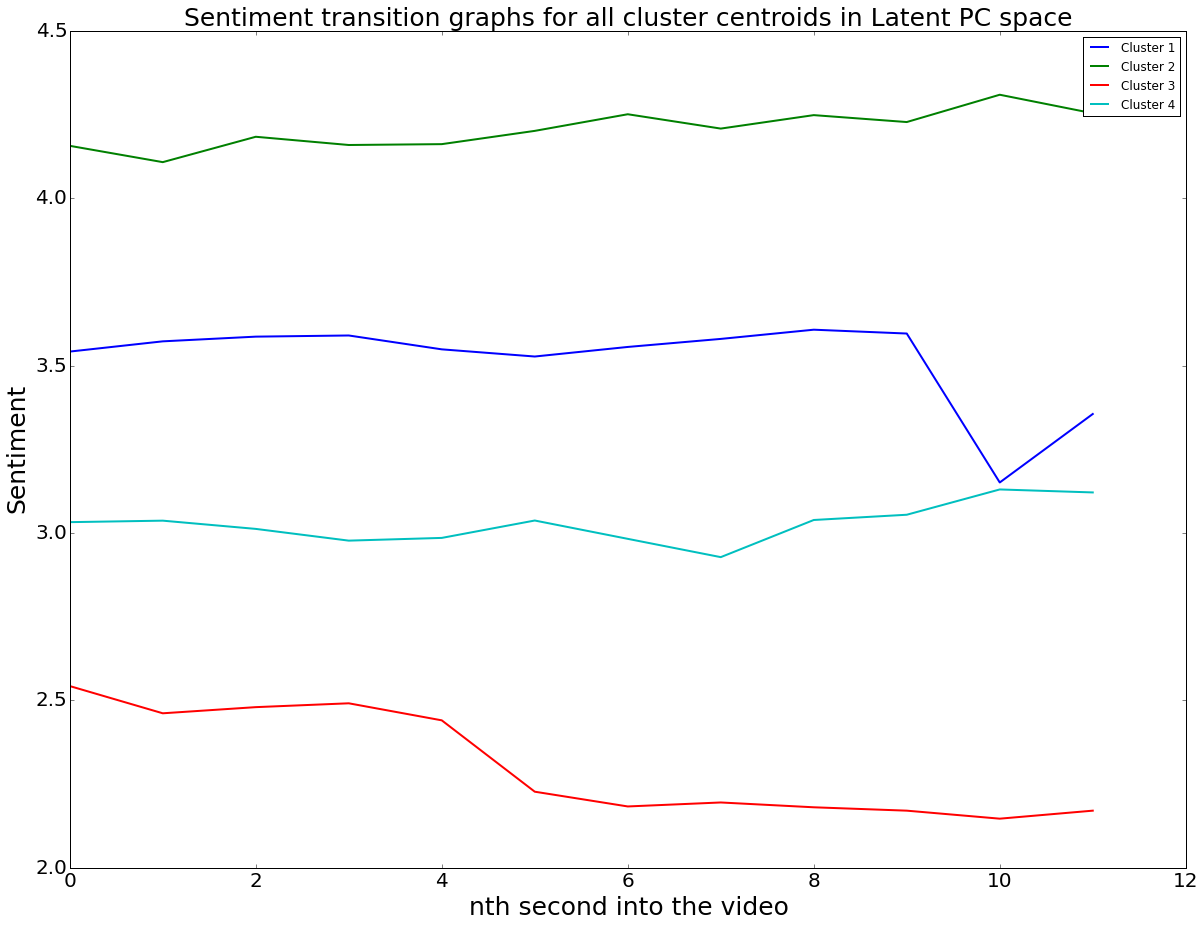

In [24]:
low_dim_centroid_final,_ = kmeans(senti_matrix,4)
low_dim_idx_final,_ = vq(senti_matrix,low_dim_centroid_final)

fig, ax = plt.subplots()
fig.set_size_inches(20, 15)
plt.rc('xtick', labelsize=20) 
plt.rc('ytick', labelsize=20)
plt.title("Sentiment transition graphs for all cluster centroids in Latent PC space", fontsize = 25)
plt.plot(low_dim_centroid_final[0], linewidth = 2.0)
plt.plot(low_dim_centroid_final[1], linewidth = 2.0)
plt.plot(low_dim_centroid_final[2], linewidth = 2.0)
plt.plot(low_dim_centroid_final[3], linewidth = 2.0)
#plt.plot(centroid_final[4], linewidth = 2.0 )
# plt.plot(centroid_final[5], linewidth = 2.0 )
# plt.plot(centroid_final[6], linewidth = 2.0 )

plt.xlabel("nth second into the video", fontsize = 25)
plt.ylabel("Sentiment", fontsize = 25)
plt.legend(['Cluster 1', 'Cluster 2' , 'Cluster 3' 
            ,'Cluster 4'
            ,'Cluster 5'
            #,'Cluster 6'
            #,'Cluster 7'
            
           ])
plt.show()

In [34]:
def autocorr(x):
    result = np.correlate(x, x, mode='full')
    return result[result.size/2:]

def findAutocorr(sentimatrix):
    autocorr_matrix = []
    for i in range(senti_matrix.shape[0]):
        autocorr_matrix.append(list(autocorr(senti_matrix[i])))
    return np.asarray(autocorr_matrix)

In [35]:
autocorr_matrix = findAutocorr(senti_matrix)

In [52]:
unpop_auto = np.median(autocorr_matrix,axis=0)

In [53]:
pop_auto = [ 169.87016908,  151.11420728,  136.56716859,  122.49555896,  108.67322631,
   95.00859467,   81.30806359,   67.6673927,    54.13310193,   40.54972758,
   26.97355304,   13.55021399]

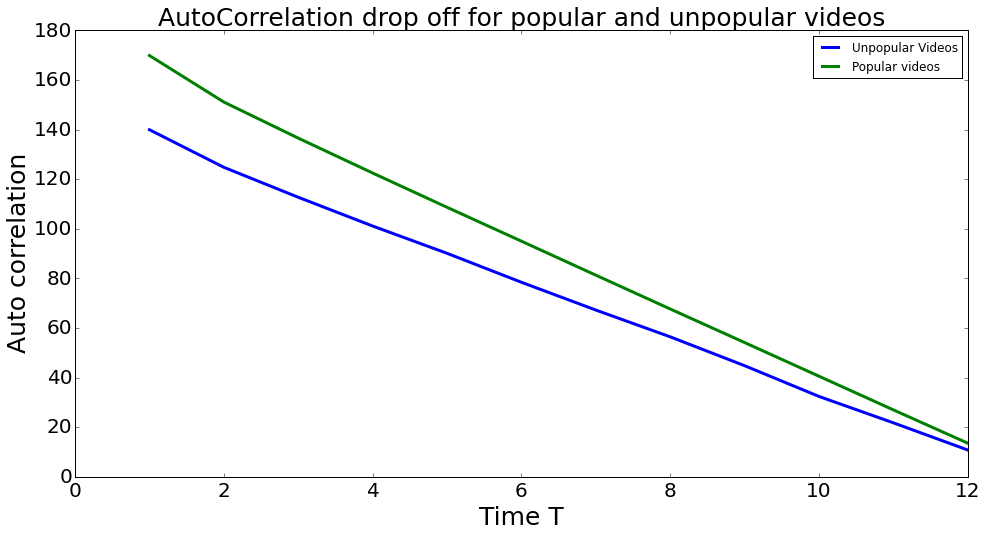

In [54]:
fig, ax = plt.subplots()
fig.set_size_inches(16, 8)
plt.rc('xtick', labelsize=20) 
plt.rc('ytick', labelsize=20)
x = np.arange(1,13)
plt.plot(x,unpop_auto ,linewidth = 3.0)
plt.plot(x,pop_auto ,linewidth = 3.0)
plt.xlabel("Time T", fontsize = 25)
plt.ylabel("Auto correlation", fontsize = 25)
plt.title("AutoCorrelation drop off for popular and unpopular videos", fontsize = 25)
plt.legend(['Unpopular Videos', 'Popular videos' ]) 
plt.show()